In [41]:
! pip install catboost

     |████████████████████████████████| 66.1MB 56kB/s 


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math, time, random, datetime
import missingno
import seaborn as sns
plt.style.use("seaborn-whitegrid")
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
! pip install ppscore 
import ppscore as pps 

In [ ]:
from google.colab import files
train_data = files.upload()

In [ ]:
from google.colab import files
test_data = files.upload()

In [13]:
df1 = pd.read_csv("train.csv")

In [6]:
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Using Predictive Power Score to view correlation

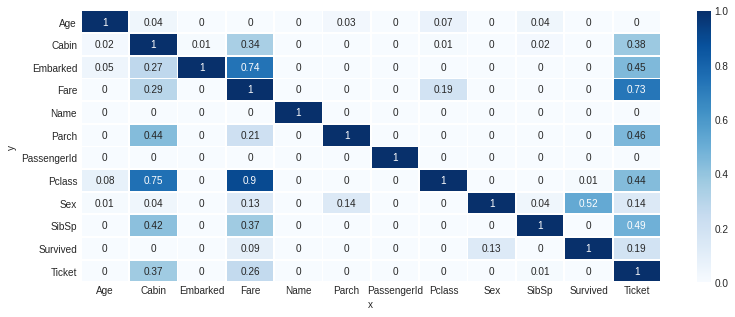

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
fig = plt.figure(figsize=(13,5))
matrix_df = pps.matrix(df1)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_df = matrix_df.apply(lambda x: round(x, 2)) 
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.75, annot=True)

***Grouping the sibling and Parch groups together to identify the number of family numbers***

In [14]:
df1["Family_size"] = df1["SibSp"] + df1["Parch"] + 1
df1.drop(["Parch","SibSp"],axis=1,inplace=True)
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S,1


**Keeping the relevant titles in "Name"**

In [15]:
def snippet(value):
  cut = value.split(", ")[1].split(".")[0]
  return cut

In [16]:
df1.Name = df1.Name.apply(lambda x: snippet(x))
df1.Name.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [18]:
df1.Name.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Mme               1
Jonkheer          1
Ms                1
Lady              1
Don               1
Sir               1
the Countess      1
Capt              1
Name: Name, dtype: int64

In [22]:
df1["Name"] = df1["Name"].replace(["Lady", "the Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
df1["Name"] = df1["Name"].replace("Mlle", "Miss")
df1["Name"] = df1["Name"].replace("Ms", "Miss")
df1["Name"] = df1["Name"].replace("Mme", "Mrs")
df1.Name.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Name, dtype: int64

In [23]:
df2 = df1.drop(["PassengerId", "Ticket", "Cabin", "Embarked"], axis = 1)

In [24]:
df2.head()

,Survived,Pclass,Name,Sex,Age,Fare,Family_size
0,0,3,Mr,male,22.0,7.2500,2
1,1,1,Mrs,female,38.0,71.2833,2
2,1,3,Miss,female,26.0,7.9250,1
3,1,1,Mrs,female,35.0,53.1000,2
4,0,3,Mr,male,35.0,8.0500,1


In [25]:
print (len(df2.index))
df2.describe()

891


,Survived,Pclass,Age,Fare,Family_size
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,32.204208,1.904602
std,0.486592,0.836071,14.526497,49.693429,1.613459
min,0.000000,1.000000,0.420000,0.000000,1.000000
25%,0.000000,2.000000,20.125000,7.910400,1.000000
50%,0.000000,3.000000,28.000000,14.454200,1.000000
75%,1.000000,3.000000,38.000000,31.000000,2.000000
max,1.000000,3.000000,80.000000,512.329200,11.000000


**Best to view the distribution of values**

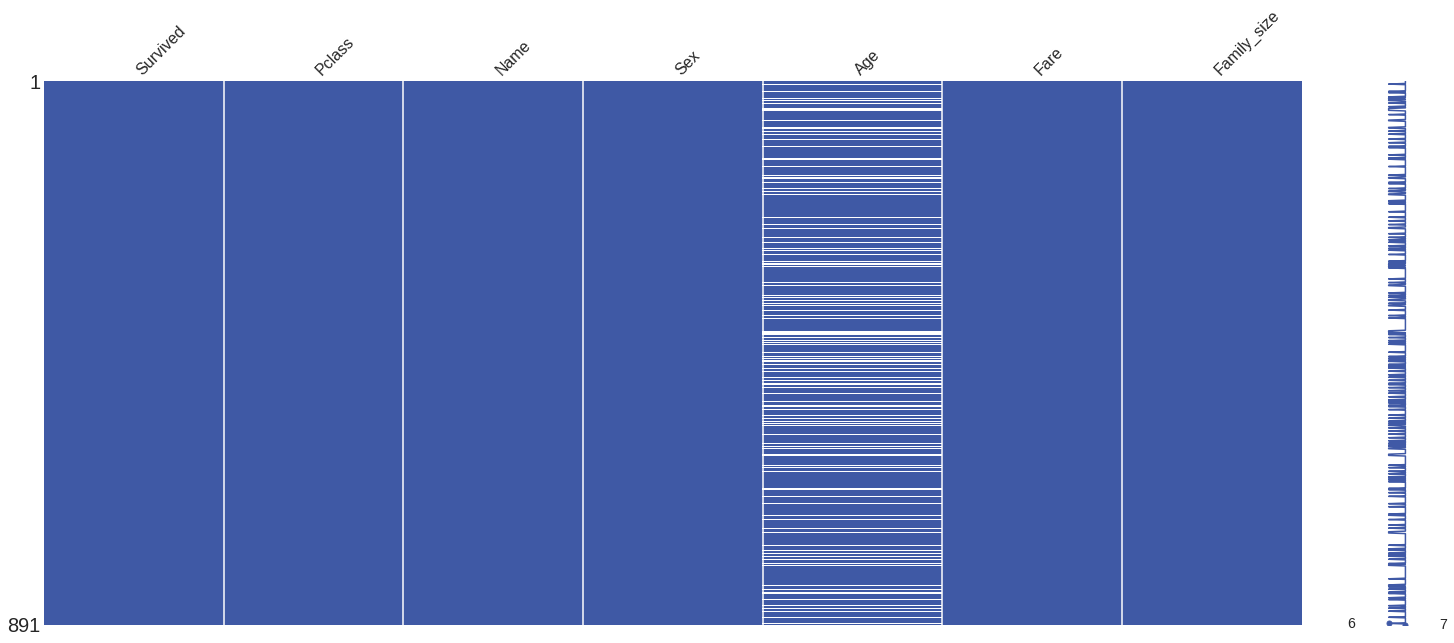

In [26]:
missingno.matrix(df2, color = (0.25, 0.35, 0.65))

It appears that the age value has many null values

In [27]:
df2.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age            177
Fare             0
Family_size      0
dtype: int64

**Fill empty Age values with the mean for each Pclass group**

In [29]:
df2["Age"] = df2.groupby("Pclass").transform(lambda x: x.fillna(x.median()))["Age"]

In [30]:
df2.Age.isnull().sum()

0

0    549
1    342
Name: Survived, dtype: int64
          Pclass  Name  Sex  Age  Fare  Family_size
Survived                                           
0            549   549  549  549   549          549
1            342   342  342  342   342          342


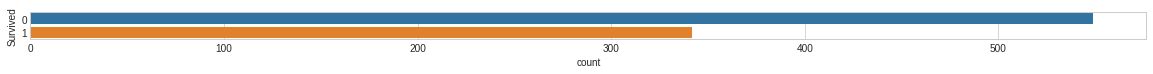

In [31]:
fig = plt.figure(figsize=(20,0.5))
sns.countplot(y="Survived", data=df2)
print(df2.Survived.value_counts())
print(df2.groupby("Survived").agg("count"))

This histogram will show the outliers,for age...beware of overfitting though!

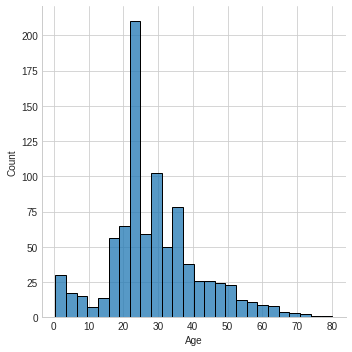

In [32]:
sns.displot(df2.Age)
#df2.Age.plot.hist()   another way to show the data spread

**Time to remove the age outliers**

In [33]:
df2.dropna(axis=0, inplace=True)

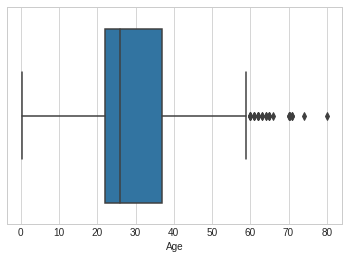

In [34]:
sns.boxplot(x=df2['Age'])

In [35]:
st = np.std(df2.Age)
mean = np.mean(df2.Age)
st

13.237097358289484

In [36]:
def snip(value):
  threshold1 = 3
  threshold2 = -3
  z = (value-mean)/st 
  if (z > threshold1) or (z < threshold2):
    value = np.nan          
  return value

In [37]:
df2.Age = df2.Age.apply(lambda x: snip(x))

In [38]:
df2.dropna(axis=0,inplace=True)
df2.Age.shape

(884,)

**One hot encoding**

In [39]:
dummies = pd.get_dummies(df2.Sex)
dummy2 = pd.get_dummies(df2.Pclass,prefix="P_class")
dummy3 = pd.get_dummies(df2.Name,prefix="Title")
df3 = pd.concat([df2,dummies,dummy2,dummy3], axis=1)
df3.drop(["Sex","Pclass","Name"],axis=1,inplace=True)

In [40]:
df3.head()

,Survived,Age,Fare,Family_size,female,male,P_class_1,P_class_2,P_class_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,22.0,7.2500,2,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,2,1,0,1,0,0,0,0,0,1,0
2,1,26.0,7.9250,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,53.1000,2,1,0,1,0,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,0,1,0,0,1,0,0


**Processing the data for training using Catboost**

In [169]:
X = preprocessing.scale(np.array(df3.drop(["Survived"],axis=1)))
y = np.array(df3.Survived)
print (X.shape,y.shape)

(884, 13) (884,)


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [171]:
model = CatBoostClassifier(custom_loss = ["Accuracy"],logging_level="Silent",loss_function='Logloss',iterations=1500)
model.fit(X_train,y_train, eval_set=(X_test,y_test))
acc_catboost = round(model.score(X_train, y_train) * 100, 2)

In [172]:
print ("accuracy is {}%".format(acc_catboost))

accuracy is 93.07%


In [109]:
cv_params = model.get_params()
cv_data = cv(Pool(X,y),params=cv_params)
acc_cv_catboost = round(np.max(cv_data["test-Accuracy-mean"]) * 100, 2)

In [110]:
print ("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))

Accuracy cross-validation 10-Fold: 84.28


**Test data**

In [173]:
tf1 = pd.read_csv("test.csv")

In [174]:
tf1["Family_size"] = tf1["SibSp"] + tf1["Parch"] + 1
tf1.drop(["Parch","SibSp"],axis=1,inplace=True)

In [175]:
tf1.Name = tf1.Name.apply(lambda x: snippet(x))

In [176]:
tf1["Name"] = tf1["Name"].replace(["Lady", "the Countess","Capt", "Col","Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
tf1["Name"] = tf1["Name"].replace("Mlle", "Miss")
tf1["Name"] = tf1["Name"].replace("Ms", "Miss")
tf1["Name"] = tf1["Name"].replace("Mme", "Mrs")

In [177]:
tf2 = tf1.drop(["PassengerId", "Ticket", "Cabin", "Embarked"], axis = 1)

In [178]:
tf2.head()

,Pclass,Name,Sex,Age,Fare,Family_size
0,3,Mr,male,34.5,7.8292,1
1,3,Mrs,female,47.0,7.0000,2
2,2,Mr,male,62.0,9.6875,1
3,3,Mr,male,27.0,8.6625,1
4,3,Mrs,female,22.0,12.2875,3


**Fitting and predicting the test data**

In [179]:
d = pd.get_dummies(tf2.Sex)
dum = pd.get_dummies(tf2.Pclass,prefix="P_class")
dumm = pd.get_dummies(tf2.Name,prefix="Title")
tf2 = pd.concat([tf2,d,dum,dumm], axis=1)
tf2.drop(["Sex","Pclass","Name"],axis=1,inplace=True)
tf2.head(2)

,Age,Fare,Family_size,female,male,P_class_1,P_class_2,P_class_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,34.5,7.8292,1,0,1,0,0,1,0,0,1,0,0
1,47.0,7.0000,2,1,0,0,0,1,0,0,0,1,0


In [180]:
test = preprocessing.scale(np.array(tf2))

In [185]:
predictions = model.predict(test)
predictions_proba = model.predict_proba(test)
print (predictions[:10])
print (predictions_proba[:10])

[0 0 0 0 1 0 0 0 0 0]
[[0.95551037 0.04448963]
 [0.95012223 0.04987777]
 [0.94316477 0.05683523]
 [0.72024088 0.27975912]
 [0.4060045  0.5939955 ]
 [0.86678212 0.13321788]
 [0.66377314 0.33622686]
 [0.91092168 0.08907832]
 [0.60555765 0.39444235]
 [0.82311951 0.17688049]]


In [186]:
submission = pd.DataFrame()
submission["PassengerId"] = tf1["PassengerId"]
submission["Survived"] = predictions
submission.Survived.apply(lambda x: int(x))
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [187]:
submission.to_csv("titanic_submission6.csv", index=False)